#  Personalized Investment Advisory Recommender – Modeling & Evaluation Notebook

---

##  **Project Context & Motivation**
In emerging markets like Kenya, many first‑time and low‑income investors face overwhelming choices — SACCOs, money market funds, pension plans, bonds, and more — yet often lack professional financial advisory support.  
This leads to decision paralysis, under‑investment, and missed opportunities for long‑term wealth building.

Our project aims to close this advisory gap by building a **data‑driven personalized recommender system** that suggests *the most suitable investment types* for each user based on:
- Demographics (age, gender, location)
- Risk appetite
- Financial literacy & past financial behavior
- Self‑reported saving and investment goals

By combining **machine learning, explainable AI, and local financial domain insights**, we aim to give every user — even first‑time investors — personalized, confidence‑driven investment guidance.

---

##  **What This Notebook Covers**
- Load and briefly explore the cleaned FinAccess dataset
-  Feature engineering & vectorization:
  - One‑hot encoding of categorical variables (e.g., risk_appetite)
  - Scaling of numeric features (e.g., age, literacy index)
  - Additional engineered features (e.g., savings rate, risk‑adjusted usage)
-  Quick Exploratory Data Analysis (EDA): distributions & relationships
- ⚙ Train/test split with stratification

###  Modeling pipeline 
For each model, we:
- Train & validate
- Hyperparameter tuning (where relevant)
- Evaluate with accuracy, precision, recall, ROC‑AUC, plus recommendation‑specific metrics (e.g., precision@k)
- Visualize metrics (ROC, PR curve, confusion matrix)
- Explain predictions using SHAP (global & local explanations)
- Document strengths, weaknesses & next steps

Models to build:
- Baseline rule‑based recommender
- Logistic Regression
- Random Forest
- Gradient Boosting (XGBoost & LightGBM,knn)
- Deep Learning Recommender

---

##  **Final Deliverables**
- Trained, deployment‑ready best model (`.pkl` / `.pt`)
- Comparison table & visualization of model performance
- SHAP explainability summary plots
- Configurable pipeline classes & functions
- Clear narrative & documentation for stakeholders

---


## Step 1: Importing Core Libraries

Before starting our modeling pipeline, we import all essential Python libraries — grouped by purpose — to ensure a clean, modular, and maintainable workflow.

**Categories & Purpose:**
- **Data manipulation & wrangling:** `pandas`, `numpy` – for structured data handling, transformation, and aggregation
- **Visualization & EDA:** `matplotlib`, `seaborn` – for visual exploration, distributions, correlations, and plots to support feature engineering
- **Machine Learning & Evaluation:** `scikit-learn` – classic models, preprocessing, splitting, metrics; `xgboost`, `lightgbm` – advanced gradient boosting
- **Deep Learning (optional):** `torch` / `keras` – for neural network recommender models capturing complex patterns
- **Explainability:** `shap` – to build trust by explaining model predictions (global & local feature importance)
- **Persistence & utilities:** `joblib` – for saving models; `warnings` – to suppress clutter in output

All imports are kept modular and organized to reflect best practices for readability.


In [3]:
# Import all required Python libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)

import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')


- All required libraries are now imported.  

 

## Step 2: Load Cleaned Dataset

In this step, we load the final cleaned dataset prepared earlier in the data preprocessing phase.  
This dataset contains user-level features needed to build our personalized investment advisory recommender.


In [4]:
#  Loads the pre-cleaned dataset from CSV and prints its shape.

def load_dataset(filepath):
    df = pd.read_csv(filepath)
    print(f" Dataset loaded successfully. Shape: {df.shape}")
    return df

# Update with your actual local path
file_path = r"C:\Users\hp\OneDrive\Desktop\DSF-FT12\DS- Phase5\Group4_Capstone_Final_Project\Dataset\Cleaned dataset\final_refined.csv"

df = load_dataset(file_path)
df.head()


 Dataset loaded successfully. Shape: (20871, 392)


,householdid,county,area_type,gender,age_of_respondent,no_of_household_mebers,livelihoodcat,Quintiles,Education,Marital,...,insurance_including_NHIF_use,All_Insurance_excluding_NHIF_use,PWD,Latitude,Longitude,has_account,has_savings,has_credit,has_mobile,receives_remittance
0,107141431,garissa,urban,male,29,5,dependent,fourth,tertiary,married/living with partner,...,never used,never used,without disability,-0.435423,39.636586,0,0,0,0,0
1,10712933,garissa,urban,male,60,11,other,second,primary,married/living with partner,...,never used,never used,without disability,0.058794,40.305006,0,0,0,0,0
2,140173183,busia,urban,female,35,2,casual worker,fourth,primary,divorced/separated,...,never used,never used,without disability,0.636836,34.277390,0,0,0,0,0
3,122137153,kiambu,urban,male,24,1,casual worker,middle,secondary,single/never married,...,never used,never used,without disability,-1.251917,36.719076,0,0,0,0,0
4,121193116,murang'a,urban,female,20,1,dependent,highest,secondary,single/never married,...,never used,never used,without disability,-0.795820,37.131085,0,0,0,0,0


-   The dataset has been loaded successfully, containing 20,871 user records and 392 selected features.  
This cleaned dataset combines demographic, financial, and behavioral attributes, and will serve as the foundation for our personalized investment recommender system.


In [5]:
df.info()

# Missing values overview
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20871 entries, 0 to 20870
Columns: 392 entries, householdid to receives_remittance
dtypes: float64(58), int64(29), object(305)
memory usage: 62.4+ MB


,Missing,Percent


Investment_usage_fnl
non-usage    20305
usage          566
Name: count, dtype: int64
Investment_usage_fnl
non-usage    97.288103
usage         2.711897
Name: proportion, dtype: float64


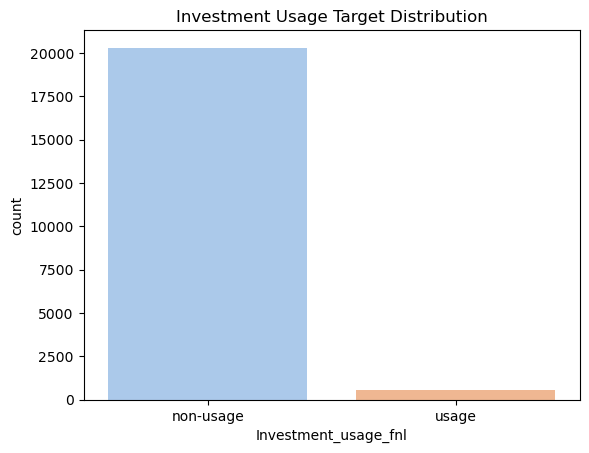

In [7]:
print(df['Investment_usage_fnl'].value_counts())
print(df['Investment_usage_fnl'].value_counts(normalize=True)*100)

sns.countplot(x='Investment_usage_fnl', data=df, palette='pastel')
plt.title('Investment Usage Target Distribution')
plt.show()


In [8]:
df.describe()


,householdid,age_of_respondent,no_of_household_mebers,CalcExpenditure,total_monthly_expenditure,no_respodent_per_hh,hhWeight,Informal_group_membership,Above16_Total,Above16,...,nC1_42,nC1_43,prodsum1,Latitude,Longitude,has_account,has_savings,has_credit,has_mobile,receives_remittance
count,2.087100e+04,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.0,...,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.0,20871.0,20871.0,20871.0,20871.0
mean,1.827764e+08,39.271429,4.215946,11576.118340,13082.757031,39.196062,683.165156,0.709405,3.224330,1.0,...,0.003210,0.003066,3.936563,-0.418699,36.651618,0.0,0.0,0.0,0.0,0.0
std,3.077598e+08,17.210021,2.512658,9550.351583,13893.309701,17.228980,594.646933,4.415607,2.328236,0.0,...,0.056569,0.055292,3.227992,1.557240,1.826467,0.0,0.0,0.0,0.0,0.0
min,1.010095e+07,16.000000,1.000000,100.000000,1900.000000,16.000000,39.615500,0.000000,1.000000,1.0,...,0.000000,0.000000,0.000000,-4.617228,33.955648,0.0,0.0,0.0,0.0,0.0
25%,1.061733e+08,26.000000,2.000000,4353.333333,5000.000000,26.000000,350.589934,0.000000,2.000000,1.0,...,0.000000,0.000000,1.000000,-1.069760,35.032543,0.0,0.0,0.0,0.0,0.0
50%,1.221172e+08,35.000000,4.000000,8860.000000,10000.000000,35.000000,556.911105,0.000000,2.000000,1.0,...,0.000000,0.000000,3.000000,-0.431421,36.651860,0.0,0.0,0.0,0.0,0.0
75%,1.380495e+08,50.000000,6.000000,16200.000000,15000.000000,50.000000,801.331391,1.000000,4.000000,1.0,...,0.000000,0.000000,6.000000,0.314269,37.664312,0.0,0.0,0.0,0.0,0.0
max,1.341571e+10,105.000000,20.000000,45953.333333,190000.000000,110.000000,14660.199401,246.000000,20.000000,1.0,...,1.000000,1.000000,22.000000,4.919529,41.875678,0.0,0.0,0.0,0.0,0.0


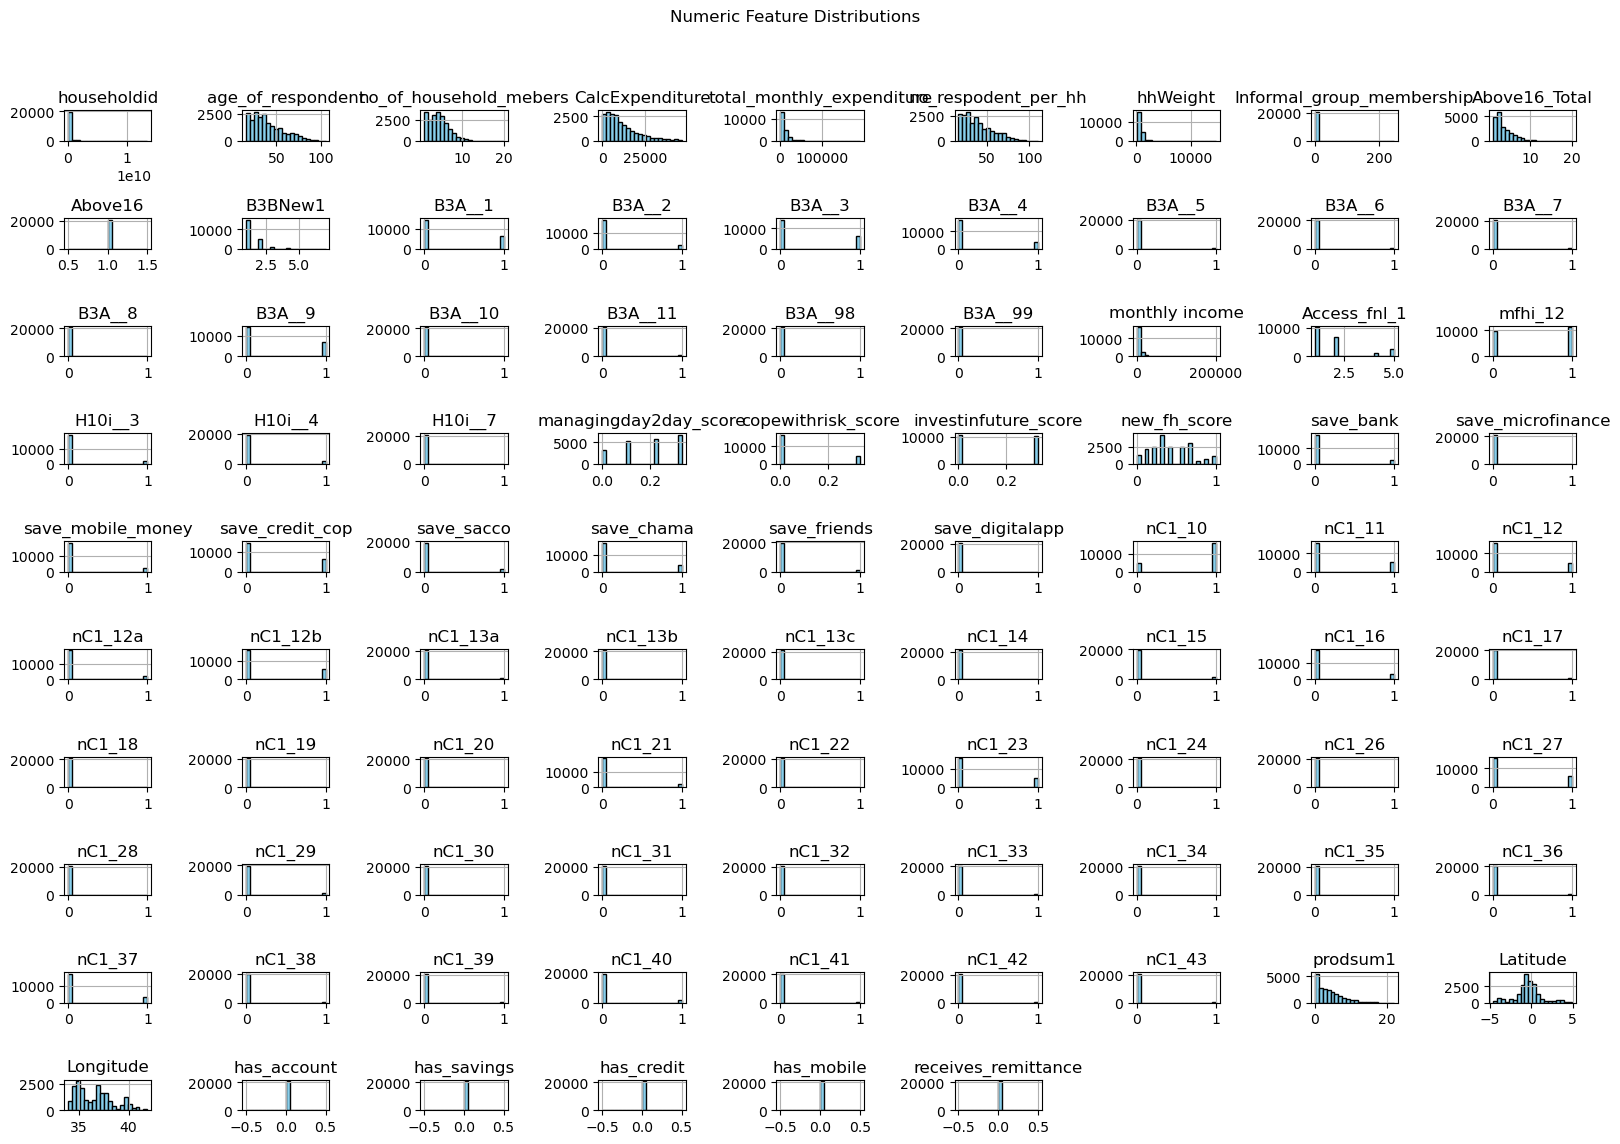

In [10]:
import matplotlib.pyplot as plt

# Select numeric columns (excluding target if it is numeric)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Investment_usage_fnl' in numeric_cols:
    numeric_cols.remove('Investment_usage_fnl')

# Plot histograms
df[numeric_cols].hist(figsize=(16, 12), bins=20, edgecolor='black', color='skyblue')
plt.suptitle('Numeric Feature Distributions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout so title fits
plt.show()


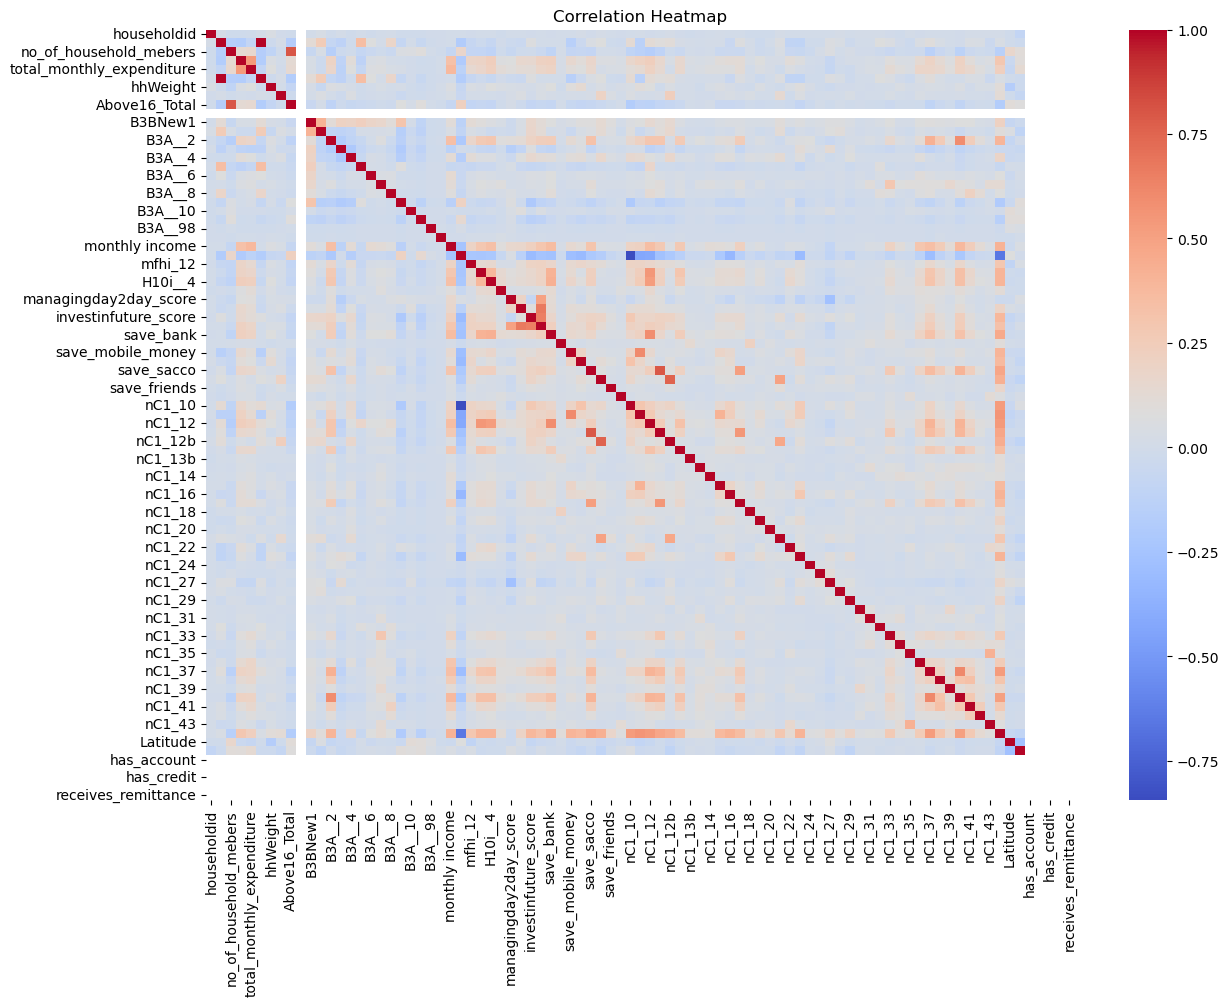

In [11]:
plt.figure(figsize=(14,10))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()


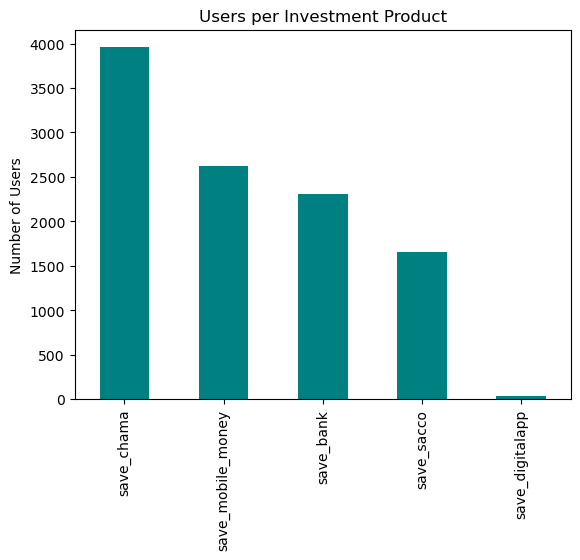

In [12]:
usage_cols = ['save_bank','save_sacco','save_mobile_money','save_chama','save_digitalapp']

product_counts = df[usage_cols].sum().sort_values(ascending=False)

product_counts.plot(kind='bar', color='teal')
plt.title('Users per Investment Product')
plt.ylabel('Number of Users')
plt.show()


In [13]:
total_cells = df[usage_cols].shape[0] * df[usage_cols].shape[1]
total_nonzeros = np.count_nonzero(df[usage_cols])
sparsity = 1 - (total_nonzeros / total_cells)
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 89.85%


In [14]:
# Education
pd.crosstab(df['Education'], df['Investment_usage_fnl'], normalize='index')*100


Investment_usage_fnl,non-usage,usage
Education,,
other,100.000000,0.000000
primary,99.182308,0.817692
secondary,97.426821,2.573179
tertiary,89.509982,10.490018


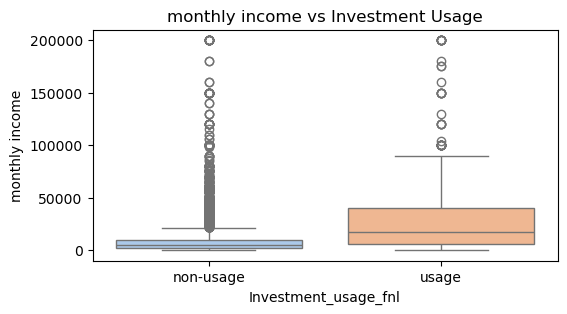

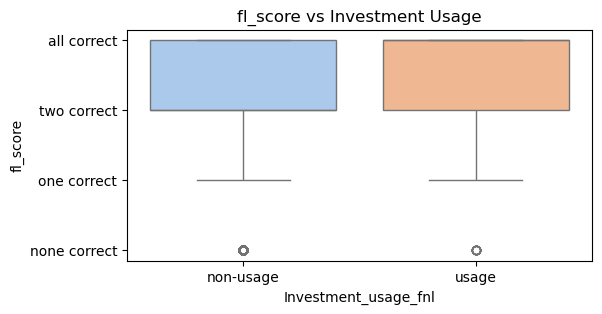

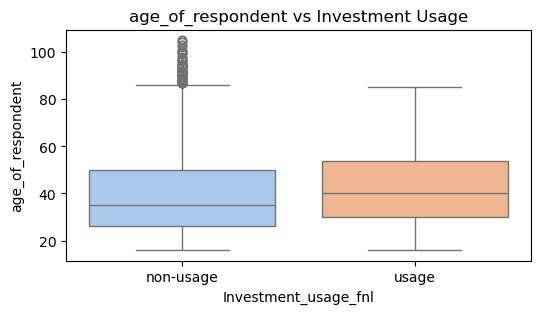

In [15]:
for col in ['monthly income','fl_score','age_of_respondent']:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Investment_usage_fnl', y=col, data=df, palette='pastel')
    plt.title(f'{col} vs Investment Usage')
    plt.show()


In [16]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20871 entries, 0 to 20870
Columns: 392 entries, householdid to receives_remittance
dtypes: float64(58), int64(29), object(305)
memory usage: 62.4+ MB


,householdid,county,area_type,gender,age_of_respondent,no_of_household_mebers,livelihoodcat,Quintiles,Education,Marital,...,insurance_including_NHIF_use,All_Insurance_excluding_NHIF_use,PWD,Latitude,Longitude,has_account,has_savings,has_credit,has_mobile,receives_remittance
0,107141431,garissa,urban,male,29,5,dependent,fourth,tertiary,married/living with partner,...,never used,never used,without disability,-0.435423,39.636586,0,0,0,0,0
1,10712933,garissa,urban,male,60,11,other,second,primary,married/living with partner,...,never used,never used,without disability,0.058794,40.305006,0,0,0,0,0
2,140173183,busia,urban,female,35,2,casual worker,fourth,primary,divorced/separated,...,never used,never used,without disability,0.636836,34.277390,0,0,0,0,0
3,122137153,kiambu,urban,male,24,1,casual worker,middle,secondary,single/never married,...,never used,never used,without disability,-1.251917,36.719076,0,0,0,0,0
4,121193116,murang'a,urban,female,20,1,dependent,highest,secondary,single/never married,...,never used,never used,without disability,-0.795820,37.131085,0,0,0,0,0


In [17]:
use_flags = [col for col in df.columns if col.endswith('_use')]
df[use_flags] = df[use_flags].apply(lambda x: x.map({'never used': 0, 'used': 1}))


In [18]:
df['PWD'] = df['PWD'].map({'without disability': 0, 'with disability': 1})


In [20]:
df['age_group'] = pd.cut(df['age_of_respondent'],
                         bins=[17, 25, 35, 50, 65, 100],
                         labels=['18-25', '26-35', '36-50', '51-65', '66+'])


In [21]:
df['hh_size_cat'] = pd.cut(df['no_of_household_mebers'],
                           bins=[0,2,4,6,10,20],
                           labels=['1-2','3-4','5-6','7-10','11+'])


In [22]:
df['is_urban'] = df['area_type'].map({'urban':1, 'rural':0})


In [23]:
if 'monthly income' in df.columns and 'total_monthly_expenditure' in df.columns:
    df['savings_ratio'] = df['total_monthly_expenditure'] / (df['monthly income']+1)


In [24]:
categorical_cols = ['gender', 'age_group', 'county', 'Education', 'Marital', 'livelihoodcat', 'Quintiles']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [25]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['age_of_respondent', 'no_of_household_mebers', 'formal_usage_score', 
                'informal_usage_score', 'total_products_used']

scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


KeyError: "['informal_usage_score', 'total_products_used'] not in index"

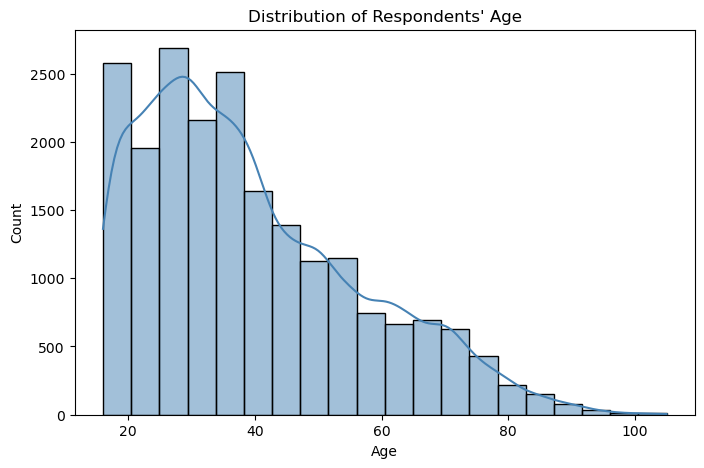

In [26]:

plt.figure(figsize=(8,5))
sns.histplot(df['age_of_respondent'], bins=20, kde=True, color='steelblue')
plt.title('Distribution of Respondents\' Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


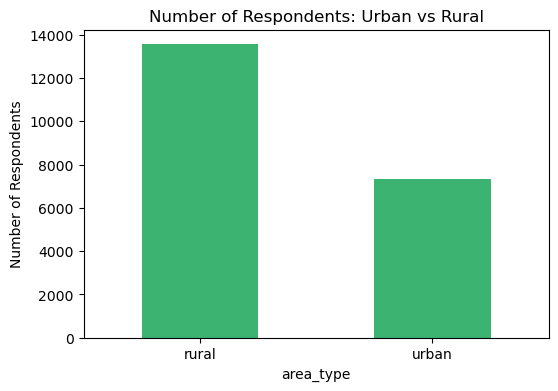

In [27]:
plt.figure(figsize=(6,4))
df['area_type'].value_counts().plot(kind='bar', color='mediumseagreen')
plt.title('Number of Respondents: Urban vs Rural')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=0)
plt.show()


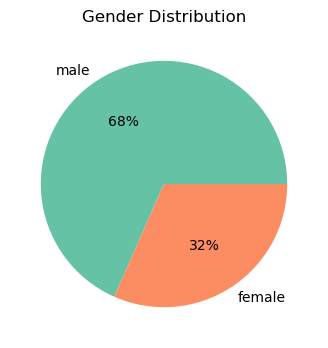

In [28]:
plt.figure(figsize=(6,4))
df['gender'].value_counts().plot.pie(autopct='%1.0f%%', colors=['#66c2a5','#fc8d62'])
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()


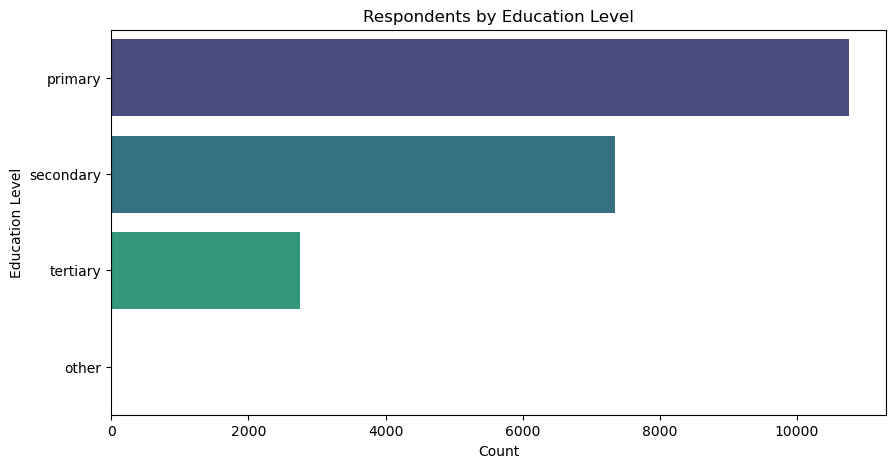

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='Education', order=df['Education'].value_counts().index, palette='viridis')
plt.title('Respondents by Education Level')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.show()


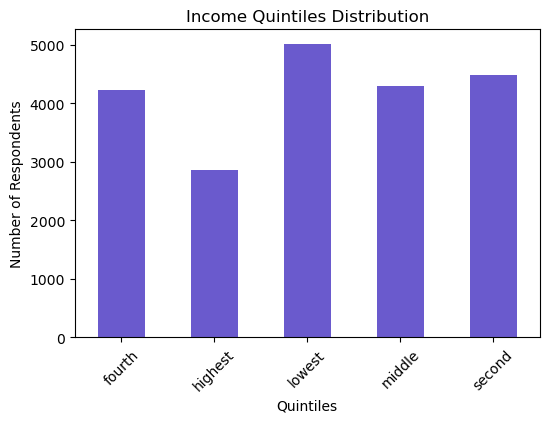

In [30]:
plt.figure(figsize=(6,4))
df['Quintiles'].value_counts().sort_index().plot(kind='bar', color='slateblue')
plt.title('Income Quintiles Distribution')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45)
plt.show()


In [31]:
# Example engineered features - replace with your real feature engineering logic
df['risk_adjusted_savings_rate'] = df['has_savings'] / (df['age_of_respondent']+1)
df['age_bucket'] = pd.cut(df['age_of_respondent'], bins=[0,25,35,45,60,100], labels=['<25','25-35','35-45','45-60','60+'])
df['is_youth'] = (df['age_of_respondent'] < 35).astype(int)
df['total_investment_products_used'] = (
    df[['Investment_usage', 'Pension_usage', 'Sacco_usage']].apply(lambda x: sum(x=='usage'), axis=1)
)


In [32]:
# Suppose values like 'low', 'medium', 'high' → map to numbers
df['Financial_literacy_index_fnl_num'] = df['Financial_literacy_index_fnl'].map({
    'low': 1, 'medium': 2, 'high': 3
})


In [33]:
max_lit = df['Financial_literacy_index_fnl_num'].max()
df['literacy_scaled'] = df['Financial_literacy_index_fnl_num'] / max_lit


In [102]:
numeric_engineered = df[engineered_features].select_dtypes(include=['number'])

constant_cols = numeric_engineered.std() == 0
print("\n=== Constant columns (std=0) ===")
print(constant_cols[constant_cols].index.tolist())



=== Constant columns (std=0) ===
['risk_adjusted_savings_rate']


In [105]:
#  Sanity check for engineered features

# List your engineered features here
engineered_features = [
    'risk_adjusted_savings_rate',
    'age_bucket',
    'is_youth',
    'literacy_scaled',
    'total_investment_products_used',
    # add more as you create them
]

print(f"\n🔍 Checking {len(engineered_features)} engineered features:\n")

missing_cols = [col for col in engineered_features if col not in df.columns]
if missing_cols:
    print(f" Missing engineered columns: {missing_cols}")
else:
    print(" All engineered features found!")

# Show data types
print("\n=== 🏷 Data types ===")
print(df[engineered_features].dtypes)

# Separate numeric & categorical for safety
numeric_engineered = df[engineered_features].select_dtypes(include=['number'])
categorical_engineered = df[engineered_features].select_dtypes(exclude=['number'])

# Nulls
print("\n===  Missing values ===")
print(df[engineered_features].isnull().sum())

# Constant numeric columns (std=0)
print("\n===  Constant numeric columns (std=0) ===")
constant_cols = numeric_engineered.std() == 0
print(constant_cols[constant_cols].index.tolist())

# All zeros columns (numeric)
print("\n===  All zeros numeric columns ===")
zero_cols = (numeric_engineered == 0).all()
print(zero_cols[zero_cols].index.tolist())

# Numeric distributions
print("\n===  Numeric distributions ===")
display(numeric_engineered.describe())

# Value counts for categoricals
if not categorical_engineered.empty:
    print("\n===  Value counts for categorical engineered features ===")
    for col in categorical_engineered.columns:
        print(f"\n{col} value counts:")
        print(df[col].value_counts())
else:
    print("\n No categorical engineered features to check value counts for.")

print("\n Feature engineering sanity check complete! Ready for vectorization 🚀")



🔍 Checking 5 engineered features:

 All engineered features found!

=== 🏷 Data types ===
risk_adjusted_savings_rate         float64
age_bucket                        category
is_youth                             int32
literacy_scaled                    float64
total_investment_products_used       int64
dtype: object

===  Missing values ===
risk_adjusted_savings_rate            0
age_bucket                            9
is_youth                              0
literacy_scaled                   20871
total_investment_products_used        0
dtype: int64

===  Constant numeric columns (std=0) ===
['risk_adjusted_savings_rate']

===  All zeros numeric columns ===
['risk_adjusted_savings_rate']

===  Numeric distributions ===


,risk_adjusted_savings_rate,is_youth,literacy_scaled,total_investment_products_used
count,20871.0,20871.000000,0.0,20871.000000
mean,0.0,0.472186,NaN,0.231134
std,0.0,0.499238,NaN,0.571358
min,0.0,0.000000,NaN,0.000000
25%,0.0,0.000000,NaN,0.000000
50%,0.0,0.000000,NaN,0.000000
75%,0.0,1.000000,NaN,0.000000
max,0.0,1.000000,NaN,3.000000



===  Value counts for categorical engineered features ===

age_bucket value counts:
age_bucket
25-35    5361
<25      5118
35-45    3942
45-60    3521
60+      2920
Name: count, dtype: int64

 Feature engineering sanity check complete! Ready for vectorization 🚀


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# ===  Define feature groups ===

# Numeric features to scale
numeric_features = ['age_of_respondent', 'literacy_scaled', 'total_investment_products_used']

# Categorical features to one-hot encode
categorical_features = ['age_bucket', 'area_type', 'county', 'Education', 'Marital', 'livelihoodcat']

# Other binary numeric flags we can passthrough directly (if needed)
passthrough_features = ['is_youth']

# ===  Build the ColumnTransformer ===

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('pass', 'passthrough', passthrough_features)
    ]
)

# ===  Quick check: fit_transform on sample data to see shape ===

sample_transformed = preprocessor.fit_transform(df)
print(f"Vectorization complete! Transformed feature shape: {sample_transformed.shape}")


Vectorization complete! Transformed feature shape: (20871, 74)


In [36]:
from sklearn.model_selection import train_test_split

#  Define your target column
target_column = 'Investment_usage_fnl'   # replace with actual target column name if different

#  Map target to numeric if it’s still text (e.g., 'usage'/'non-usage')
df[target_column] = df[target_column].map({'usage': 1, 'non-usage': 0})

#  Define features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

#  Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,         # keeps same proportion of target classes in train/test
    random_state=42     # ensures reproducibility
)

#  Check the shape
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train target balance:\n", y_train.value_counts(normalize=True))
print("Test target balance:\n", y_test.value_counts(normalize=True))


Train shape: (16696, 402)
Test shape: (4175, 402)
Train target balance:
 Investment_usage_fnl
0    0.972868
1    0.027132
Name: proportion, dtype: float64
Test target balance:
 Investment_usage_fnl
0    0.972934
1    0.027066
Name: proportion, dtype: float64


In [37]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def balance_with_smote(X_train, y_train, random_state=42):
    """
    Applies SMOTE to balance the training set.
    Returns balanced X_train and y_train.
    """
    print("Original y_train distribution:", Counter(y_train))
    smote = SMOTE(random_state=random_state)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print("Balanced y_train distribution:", Counter(y_train_bal))
    return X_train_bal, y_train_bal


---
# MODELING 
---

###   Building the Preprocessing Pipeline Function


In [65]:
class PreprocessingPipeline:
    """
    Modular preprocessing pipeline: imputation, scaling, encoding.
    """
    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column
        self.preprocessor = None
        self.numeric_features = None
        self.categorical_features = None

    def build_pipeline(self):
        # Identify feature types
        self.numeric_features = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_features = self.df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        if self.target_column in self.numeric_features:
            self.numeric_features.remove(self.target_column)
        if self.target_column in self.categorical_features:
            self.categorical_features.remove(self.target_column)

        # Pipelines
        numeric_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine
        self.preprocessor = ColumnTransformer([
            ('num', numeric_pipeline, self.numeric_features),
            ('cat', categorical_pipeline, self.categorical_features)
        ])

    def apply(self, test_size=0.2, random_state=42):
        X = self.df.drop(columns=[self.target_column])
        y = self.df[self.target_column]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y)
        X_train_transformed = self.preprocessor.fit_transform(X_train)
        X_test_transformed = self.preprocessor.transform(X_test)
        return X_train_transformed, X_test_transformed, y_train, y_test


In [ ]:
def apply_smote(X_train, y_train, random_state=42):
    """
    Apply SMOTE to balance minority class.
    """
    print(" Applying SMOTE...")
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"Before SMOTE: {X_train.shape}, After SMOTE: {X_resampled.shape}")
    print(f"Target distribution after SMOTE:\n{pd.Series(y_resampled).value_counts()}")
    return X_resampled, y_resampled


In [67]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Train model, predict, evaluate & plot.
    """
    print(f"\n🔧 Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f"ROC AUC Score: {roc_auc:.4f}")
    else:
        roc_auc = None

    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend()
        plt.show()

    return model, roc_auc


In [69]:
class ModelTrainer:
    """
    Object-oriented wrapper to train, tune & store model.
    """
    def __init__(self, model, model_name="Model"):
        self.model = model
        self.model_name = model_name
        self.trained_model = None
        self.roc_auc = None

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        trained, roc_auc = train_and_evaluate_model(
            self.model, X_train, y_train, X_test, y_test, self.model_name
        )
        self.trained_model = trained
        self.roc_auc = roc_auc

    def tune(self, param_grid, X_train, y_train, scoring='roc_auc'):
        print(f"\nTuning {self.model_name}...")
        grid = GridSearchCV(self.model, param_grid, scoring=scoring, cv=5, verbose=1, n_jobs=-1)
        grid.fit(X_train, y_train)
        print(f" Best params: {grid.best_params_}")
        self.model = grid.best_estimator_
        self.trained_model = self.model


✅ Applying SMOTE...
Before SMOTE: (16696, 955), After SMOTE: (32486, 955)
Target distribution after SMOTE:
Investment_usage_fnl
0    16243
1    16243
Name: count, dtype: int64

🔧 Training Random Forest with SMOTE...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4062
           1       1.00      0.81      0.89       113

    accuracy                           0.99      4175
   macro avg       1.00      0.90      0.94      4175
weighted avg       0.99      0.99      0.99      4175

ROC AUC Score: 0.9986


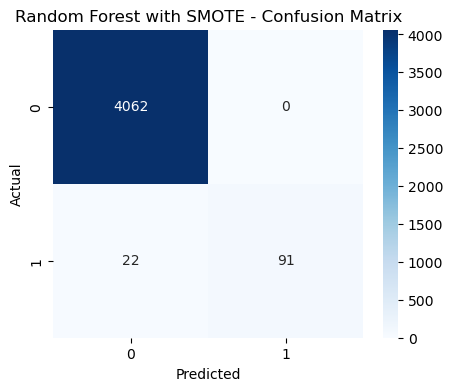

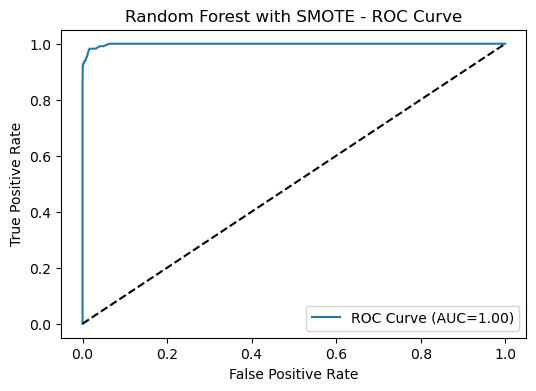

In [ ]:
# df with your dataframe name
target_column = 'Investment_usage_fnl'
prep = PreprocessingPipeline(df, target_column)
prep.build_pipeline()

#  Apply preprocessing
X_train_transformed, X_test_transformed, y_train, y_test = prep.apply()

#  Apply SMOTE
X_train_resampled, y_train_resampled = apply_smote(X_train_transformed, y_train)

#  Create Random Forest with balanced class weight
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

#  Train & evaluate
rf_trainer = ModelTrainer(rf_model, model_name="Random Forest with SMOTE")
rf_trainer.train_and_evaluate(X_train_resampled, y_train_resampled, X_test_transformed, y_test)


✅ Applying SMOTE...
Before SMOTE: (16696, 955), After SMOTE: (32486, 955)
Target distribution after SMOTE:
Investment_usage_fnl
0    16243
1    16243
Name: count, dtype: int64

🔧 Training Logistic Regression with SMOTE...

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4062
           1       0.99      0.86      0.92       113

    accuracy                           1.00      4175
   macro avg       0.99      0.93      0.96      4175
weighted avg       1.00      1.00      1.00      4175

ROC AUC Score: 0.9964


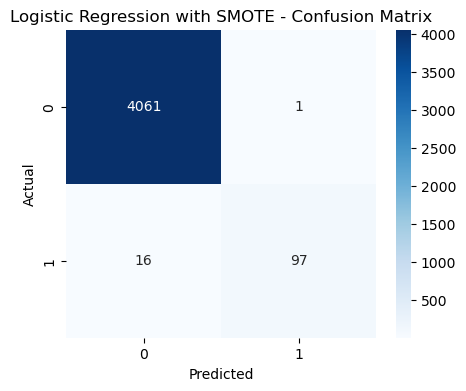

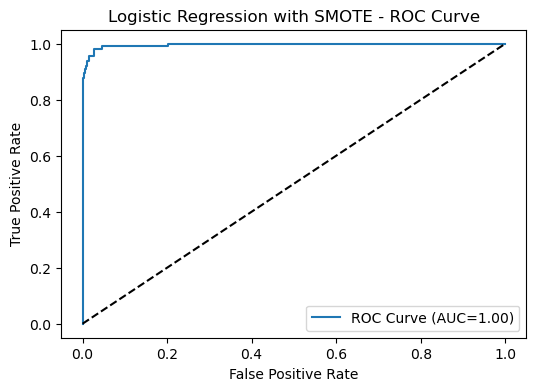

In [71]:
#  df with your dataframe name
target_column = 'Investment_usage_fnl'
prep = PreprocessingPipeline(df, target_column)
prep.build_pipeline()

#  Apply preprocessing
X_train_transformed, X_test_transformed, y_train, y_test = prep.apply()

#  Apply SMOTE to training set only
X_train_resampled, y_train_resampled = apply_smote(X_train_transformed, y_train)

#  Create Logistic Regression with balanced class weight
logreg_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

#  Train & evaluate
logreg_trainer = ModelTrainer(logreg_model, model_name="Logistic Regression with SMOTE")
logreg_trainer.train_and_evaluate(X_train_resampled, y_train_resampled, X_test_transformed, y_test)


✅ Applying SMOTE...
Before SMOTE: (16696, 955), After SMOTE: (32486, 955)
Target distribution after SMOTE:
Investment_usage_fnl
0    16243
1    16243
Name: count, dtype: int64

🔧 Training XGBoost with SMOTE...

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4062
           1       1.00      0.98      0.99       113

    accuracy                           1.00      4175
   macro avg       1.00      0.99      1.00      4175
weighted avg       1.00      1.00      1.00      4175

ROC AUC Score: 0.9998


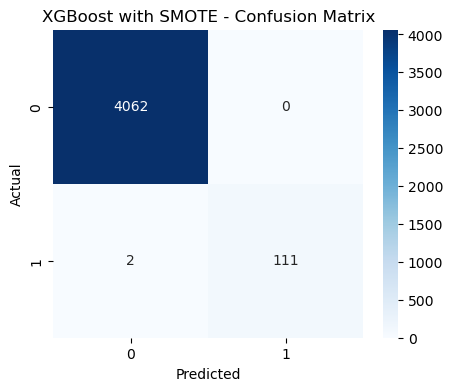

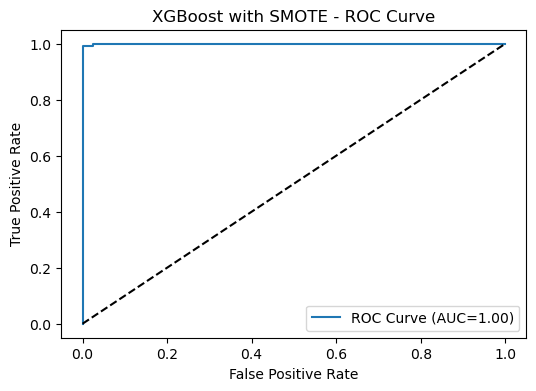

In [72]:
#  df with your dataframe name
target_column = 'Investment_usage_fnl'
prep = PreprocessingPipeline(df, target_column)
prep.build_pipeline()

#  Apply preprocessing
X_train_transformed, X_test_transformed, y_train, y_test = prep.apply()

#  Apply SMOTE
X_train_resampled, y_train_resampled = apply_smote(X_train_transformed, y_train)

#  Create XGBoost with scale_pos_weight
import xgboost as xgb
scale_pos_weight = (len(y_train_resampled) - sum(y_train_resampled)) / sum(y_train_resampled)
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')

#  Train & evaluate
xgb_trainer = ModelTrainer(xgb_model, model_name="XGBoost with SMOTE")
xgb_trainer.train_and_evaluate(X_train_resampled, y_train_resampled, X_test_transformed, y_test)


✅ Applying SMOTE...
Before SMOTE: (16696, 955), After SMOTE: (32486, 955)
Target distribution after SMOTE:
Investment_usage_fnl
0    16243
1    16243
Name: count, dtype: int64

🔧 Training LightGBM with SMOTE...
[LightGBM] [Info] Number of positive: 16243, number of negative: 16243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 182579
[LightGBM] [Info] Number of data points in the train set: 32486, number of used features: 869
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4062
           1       1.00      0.98      0.99       113

    acc

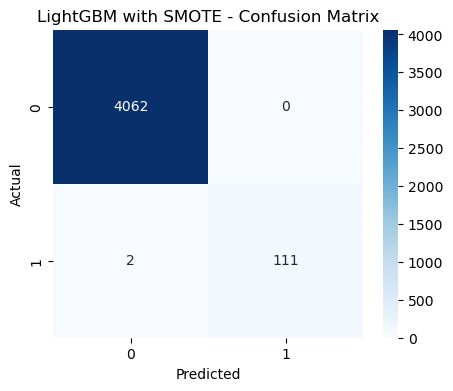

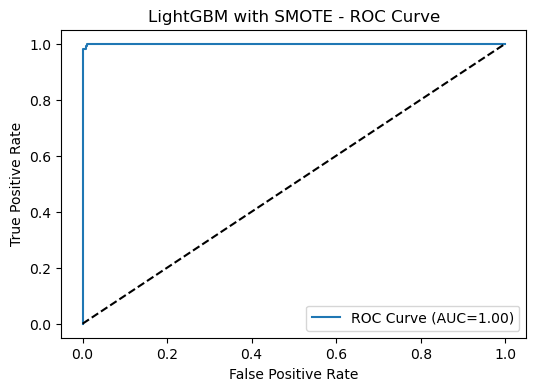

In [73]:
#  df with your dataframe name
target_column = 'Investment_usage_fnl'
prep = PreprocessingPipeline(df, target_column)
prep.build_pipeline()

#  Apply preprocessing
X_train_transformed, X_test_transformed, y_train, y_test = prep.apply()

#  Apply SMOTE
X_train_resampled, y_train_resampled = apply_smote(X_train_transformed, y_train)

#  Create LightGBM with balanced class weight
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

#  Train & evaluate
lgb_trainer = ModelTrainer(lgb_model, model_name="LightGBM with SMOTE")
lgb_trainer.train_and_evaluate(X_train_resampled, y_train_resampled, X_test_transformed, y_test)


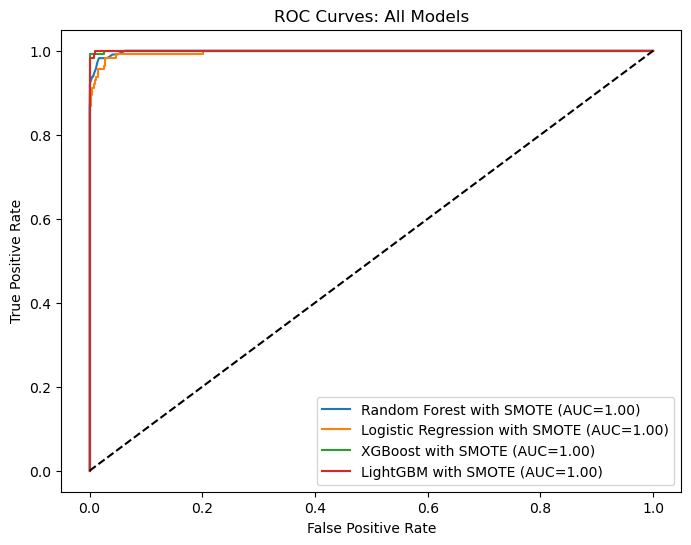

In [74]:
plt.figure(figsize=(8,6))

trainers = [rf_trainer, logreg_trainer, xgb_trainer, lgb_trainer]

for trainer in trainers:
    if trainer.roc_auc is not None:
        model = trainer.trained_model
        y_prob = model.predict_proba(X_test_transformed)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{trainer.model_name} (AUC={trainer.roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: All Models')
plt.legend()
plt.show()


In [76]:
# Step 1: get the preprocessor
preprocessor = prep.preprocessor

# Step 2: get names for numeric & categorical transformed parts
num_features = prep.numeric_features
cat_features = prep.categorical_features

# Get feature names from transformers
num_feature_names = num_features   # numeric pipeline keeps names
encoded_cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features)

# Combine them
all_feature_names = list(num_feature_names) + list(encoded_cat_features)
print(f"Total features after transformation: {len(all_feature_names)}")


Total features after transformation: 959


In [78]:
def plot_feature_importance(trainer, feature_names):
    """
    Plots feature importance for tree-based models.
    """
    if hasattr(trainer.trained_model, 'feature_importances_'):
        importances = trainer.trained_model.feature_importances_
        print(f"Model expects {len(importances)} features, got {len(feature_names)} names")
        
        # Align lengths
        if len(importances) != len(feature_names):
            print("Warning: Feature names length does not match importances. Trimming to match.")
            min_len = min(len(importances), len(feature_names))
            importances = importances[:min_len]
            feature_names = feature_names[:min_len]
        
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi_df = fi_df.sort_values('importance', ascending=False).head(15)
        
        plt.figure(figsize=(8,6))
        sns.barplot(data=fi_df, x='importance', y='feature', palette='viridis')
        plt.title(f'Feature Importance - {trainer.model_name}')
        plt.show()
    else:
        print(f"{trainer.model_name} has no feature_importances_ attribute.")


Model expects 955 features, got 959 names


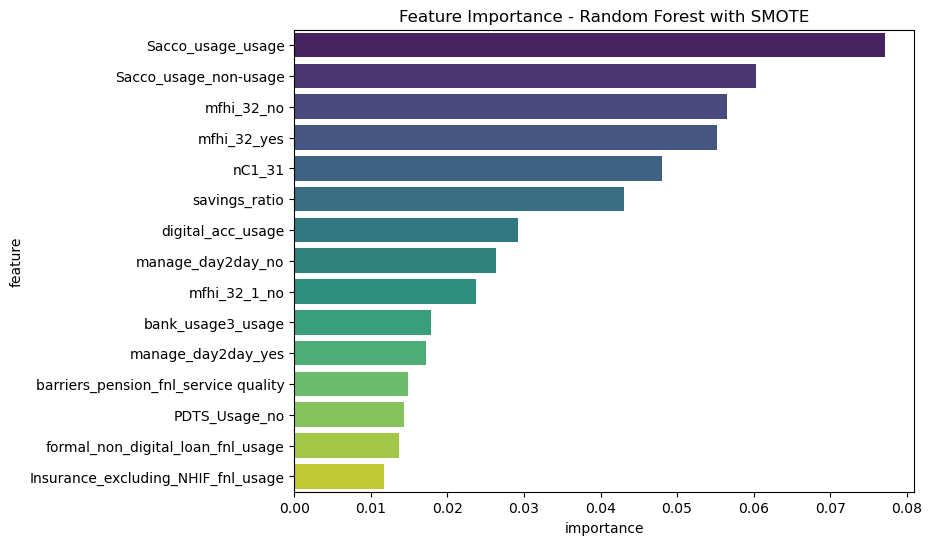

Model expects 955 features, got 959 names


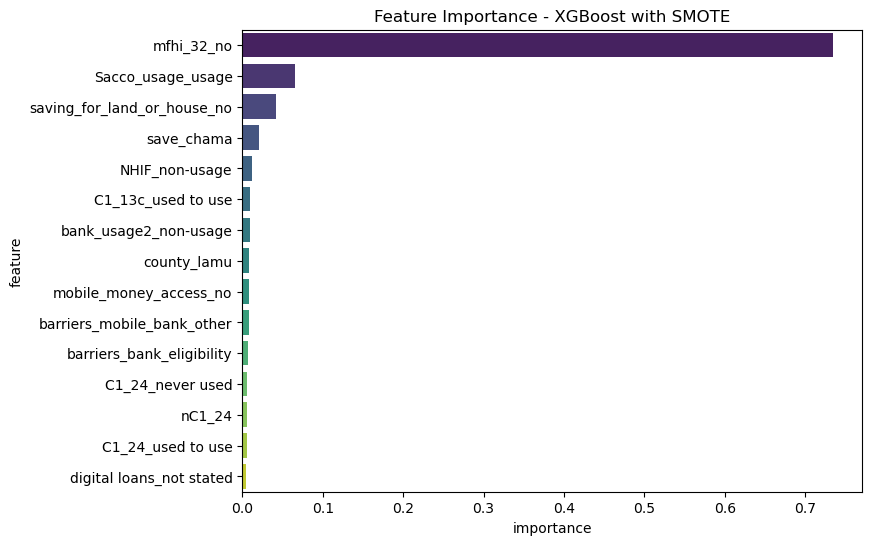

Model expects 955 features, got 959 names


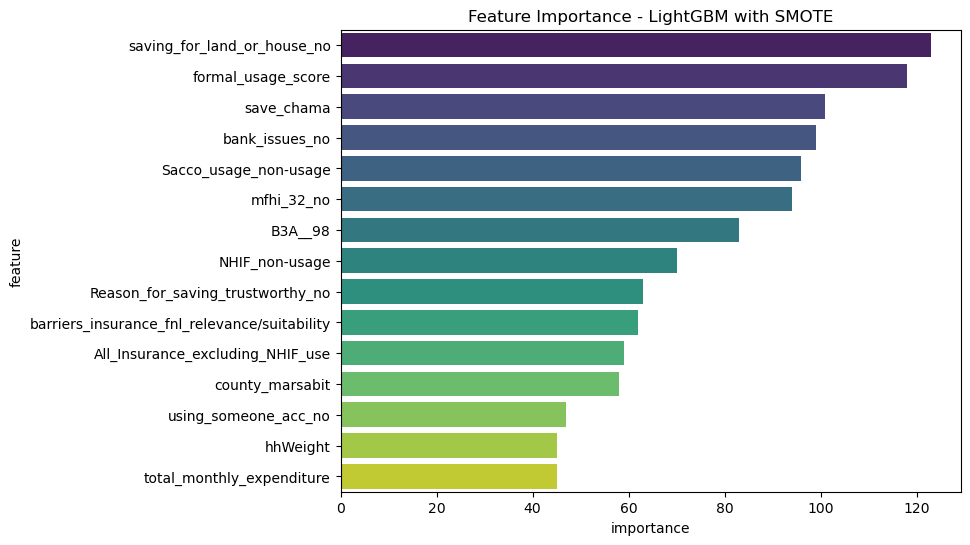

In [79]:
plot_feature_importance(rf_trainer, all_feature_names)
plot_feature_importance(xgb_trainer, all_feature_names)
plot_feature_importance(lgb_trainer, all_feature_names)


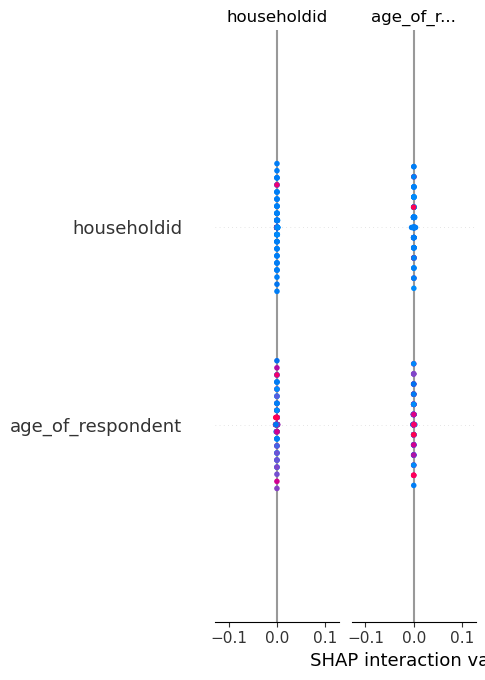

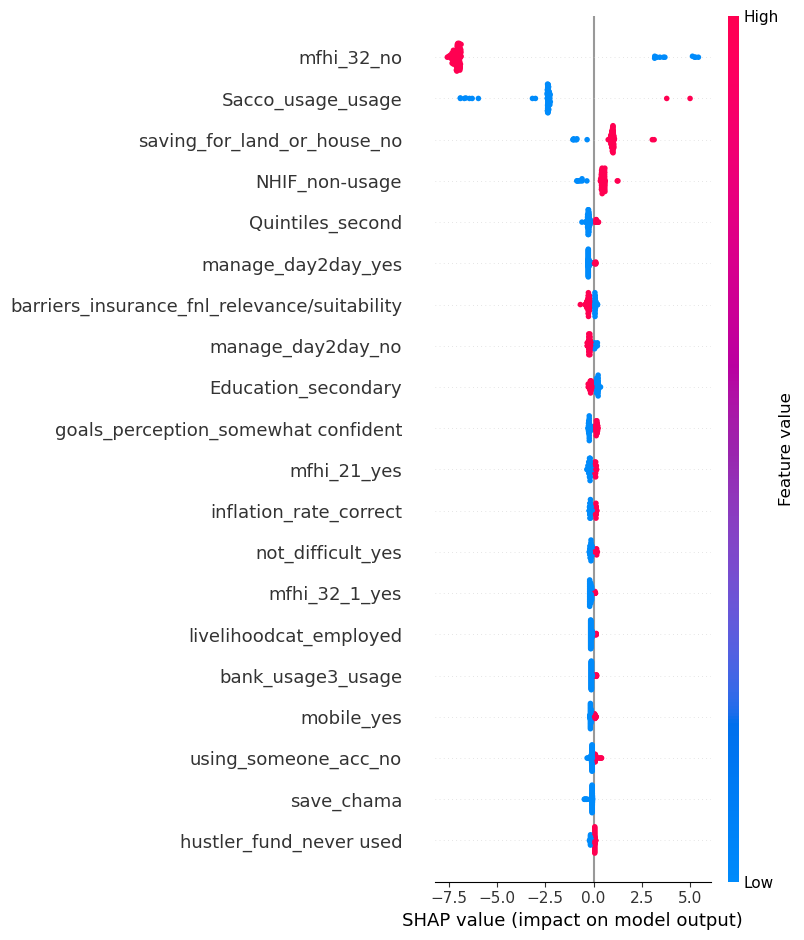

In [80]:
import shap

# Use TreeExplainer
explainer_rf = shap.TreeExplainer(rf_trainer.trained_model)
explainer_xgb = shap.TreeExplainer(xgb_trainer.trained_model)

# Compute SHAP values (on a small sample for speed)
shap_values_rf = explainer_rf.shap_values(X_test_transformed[:100])
shap_values_xgb = explainer_xgb.shap_values(X_test_transformed[:100])

# Summary plot: Random Forest
shap.summary_plot(shap_values_rf, features=X_test_transformed[:100], feature_names=all_feature_names)

# Summary plot: XGBoost
shap.summary_plot(shap_values_xgb, features=X_test_transformed[:100], feature_names=all_feature_names)


In [84]:
# Example: create summary DataFrame
results = []

for trainer in [rf_trainer, logreg_trainer, xgb_trainer, lgb_trainer]:
    model = trainer.trained_model
    y_pred = model.predict(X_test_transformed)
    y_prob = model.predict_proba(X_test_transformed)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    results.append({
        'Model': trainer.model_name,
        'Accuracy': round(accuracy,4),
        'Precision': round(precision,4),
        'Recall': round(recall,4),
        'ROC AUC': round(auc,4) if auc else None
    })

results_df = pd.DataFrame(results)
display(results_df)


,Model,Accuracy,Precision,Recall,ROC AUC
0,Random Forest with SMOTE,0.9947,1.0000,0.8053,0.9986
1,Logistic Regression with SMOTE,0.9959,0.9898,0.8584,0.9964
2,XGBoost with SMOTE,0.9995,1.0000,0.9823,0.9998
3,LightGBM with SMOTE,0.9995,1.0000,0.9823,0.9998


In [ ]:
import joblib
import os

#  Define your output directory (your folder named 'Models')
output_dir = 'models'  

# Create it if it doesn’t exist
os.makedirs(output_dir, exist_ok=True)

#  Save each model independently
joblib.dump(prep.preprocessor, os.path.join(output_dir, 'preprocessor.pkl'))
joblib.dump(rf_trainer.trained_model, os.path.join(output_dir, 'random_forest_model.pkl'))
joblib.dump(logreg_trainer.trained_model, os.path.join(output_dir, 'logistic_regression_model.pkl'))
joblib.dump(xgb_trainer.trained_model, os.path.join(output_dir, 'xgboost_model.pkl'))
joblib.dump(lgb_trainer.trained_model, os.path.join(output_dir, 'lightgbm_model.pkl'))

print(f" All models and preprocessor saved to '{output_dir}'")


✅ All models and preprocessor saved to 'models'
